In [1]:
import cdsapi
from atlite.gis import shape_availability, ExclusionContainer
from rasterio.plot import show

import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import geopandas as gpd
import pandas as pd
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
import cartopy.io.shapereader as shpreader

import xarray as xr
import atlite

In [2]:
# Enable log info to show during the process
import warnings
import logging

# warnings.simplefilter("default", DeprecationWarning)
logging.captureWarnings(True)
logging.basicConfig(level=logging.INFO)

In [3]:
# Creating a cutout for Northern Italy
cutout = atlite.Cutout(
    path="northern_italy_2.nc",
    module="era5",
    x=slice(9,11),
    y=slice(44,45),
    time=slice("2011-01","2011-12")
)

  warn(



In [4]:
cutout.prepare()

<Cutout "northern_italy_2">
 x = 9.00 ⟷ 11.00, dx = 0.25
 y = 44.00 ⟷ 45.00, dy = 0.25
 time = 2011-01-01 ⟷ 2011-12-31, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

In [5]:
cutout.data

<xarray.Dataset>
Dimensions:                                 (x: 9, y: 5, time: 8760)
Coordinates:
  * x                                       (x) float64 9.0 9.25 ... 10.75 11.0
  * y                                       (y) float64 44.0 44.25 ... 45.0
  * time                                    (time) datetime64[ns] 2011-01-01 ...
    lon                                     (x) float64 dask.array<chunksize=(9,), meta=np.ndarray>
    lat                                     (y) float64 dask.array<chunksize=(5,), meta=np.ndarray>
Data variables: (12/14)
    height                                  (y, x) float32 dask.array<chunksize=(5, 9), meta=np.ndarray>
    wnd100m                                 (time, y, x) float32 dask.array<chunksize=(100, 5, 9), meta=np.ndarray>
    wnd_azimuth                             (time, y, x) float32 dask.array<chunksize=(100, 5, 9), meta=np.ndarray>
    roughness                               (time, y, x) float32 dask.array<chunksize=(100, 5, 9), meta=np.ndarray>
    influx_toa                              (time, y, x) float32 dask.array<chunksize=(100, 5, 9), meta=np.ndarray>
    influx_direct                           (time, y, x) float32 dask.array<chunksize=(100, 5, 9), meta=np.ndarray>
    ...                                      ...
    solar_position: altitude                (time, y, x) float64 dask.array<chunksize=(100, 5, 9), meta=np.ndarray>
    solar_position: azimuth                 (time, y, x) float64 dask.array<chunksize=(100, 5, 9), meta=np.ndarray>
    solar_position: atmospheric insolation  (time, y, x) float32 dask.array<chunksize=(100, 5, 9), meta=np.ndarray>
    temperature                             (time, y, x) float32 dask.array<chunksize=(100, 5, 9), meta=np.ndarray>
    soil temperature                        (time, y, x) float32 dask.array<chunksize=(100, 5, 9), meta=np.ndarray>
    runoff                                  (time, y, x) float32 dask.array<chunksize=(100, 5, 9), meta=np.ndarray>
Attributes:
    module:             era5
    prepared_features:  ['temperature', 'height', 'runoff', 'wind', 'influx']
    chunksize_time:     100
    Conventions:        CF-1.6
    history:            2023-03-15 10:54:30 GMT by grib_to_netcdf-2.25.1: /op...

In [6]:
# PV produciton based on weather
pv_opt = cutout.pv(
    panel="CSi", orientation="latitude_optimal", clearsky_model="simple"
)

In [7]:
# Defining shape of Italy
shpfilename = shpreader.natural_earth(
    resolution="10m", category="cultural", name="admin_0_countries"
)
reader = shpreader.Reader(shpfilename)
Italy = gpd.GeoSeries(
    {r.attributes["NAME_EN"]: r.geometry for r in reader.records()},
    crs={"init": "epsg:4326"},
).reindex(["Italy"])

  in_crs_string = _prepare_from_proj_string(in_crs_string)



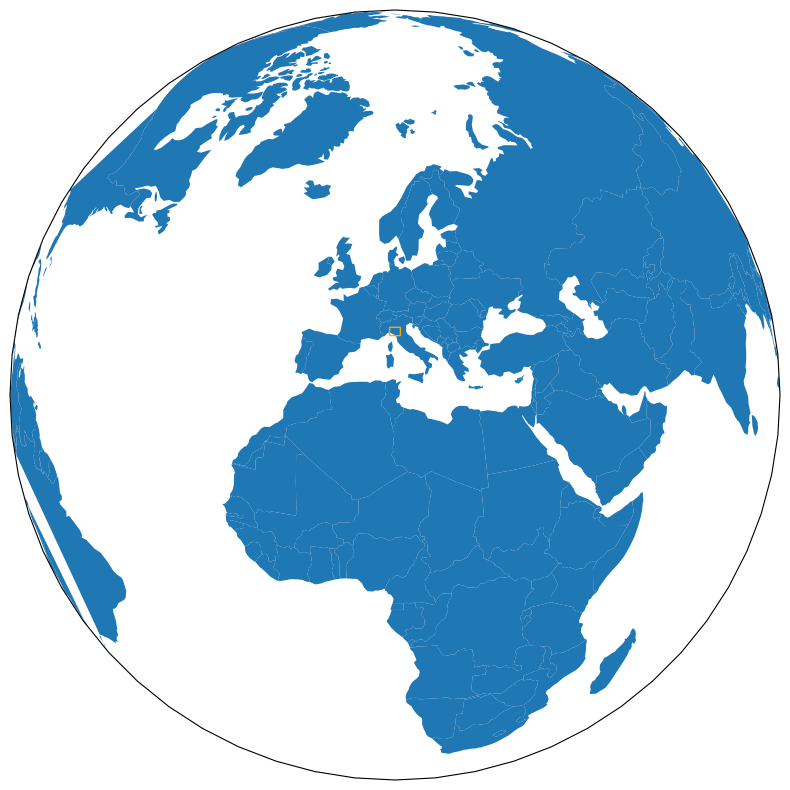

In [8]:
cells = cutout.grid
df = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
country_bound = gpd.GeoSeries(cells.unary_union)

# Creating projection (to orient Earth on the figure)
projection = ccrs.Orthographic(10, 35)
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(8, 8))
df.plot(ax=ax, transform=plate())
country_bound.plot(ax=ax, edgecolor="orange", facecolor="None", transform=plate())
fig.tight_layout()


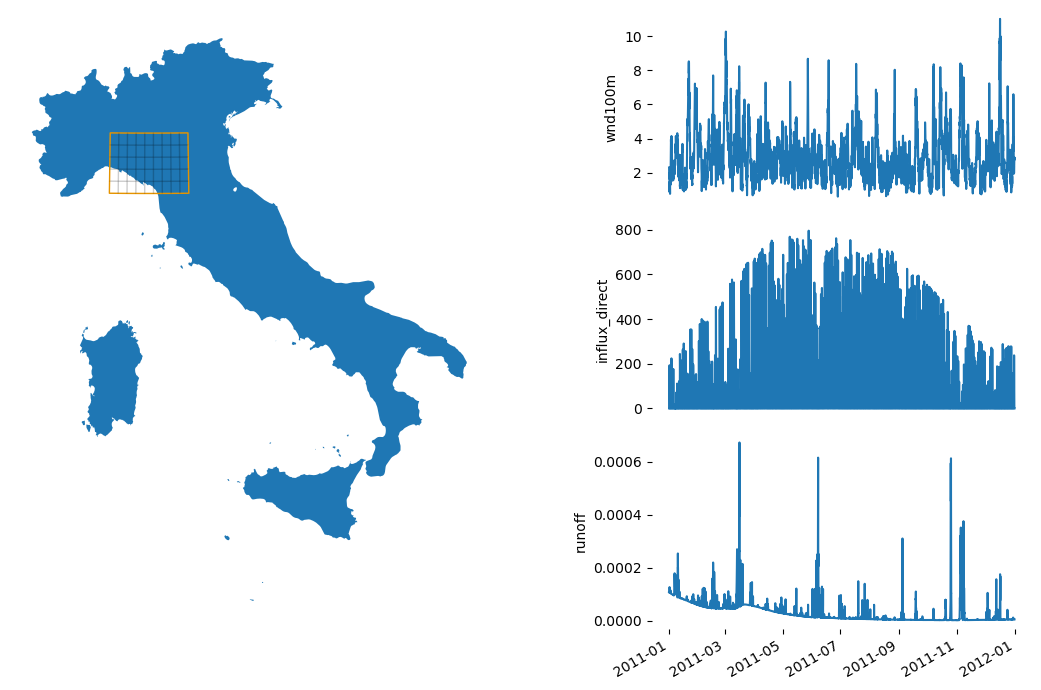

In [9]:
fig = plt.figure(figsize=(12, 7))
gs = GridSpec(3, 3, figure=fig)

ax = fig.add_subplot(gs[:, 0:2], projection=projection)
plot_grid_dict = dict(
    alpha=0.1,
    edgecolor="k",
    zorder=4,
    aspect="equal",
    facecolor="None",
    transform=plate(),
)
Italy.plot(ax=ax, zorder=1, transform=plate(),aspect="equal")
cells.plot(ax=ax, **plot_grid_dict)
country_bound.plot(ax=ax, edgecolor="orange", facecolor="None", transform=plate())
ax.set_frame_on(False)

ax1 = fig.add_subplot(gs[0, 2])
cutout.data.wnd100m.mean(["x", "y"]).plot(ax=ax1)
ax1.set_frame_on(False)
ax1.xaxis.set_visible(False)

ax2 = fig.add_subplot(gs[1, 2], sharex=ax1)
cutout.data.influx_direct.mean(["x", "y"]).plot(ax=ax2)
ax2.set_frame_on(False)
ax2.xaxis.set_visible(False)

ax3 = fig.add_subplot(gs[2, 2], sharex=ax1)
cutout.data.runoff.mean(["x", "y"]).plot(ax=ax3)
ax3.set_frame_on(False)
ax3.set_xlabel(None)
fig.tight_layout()

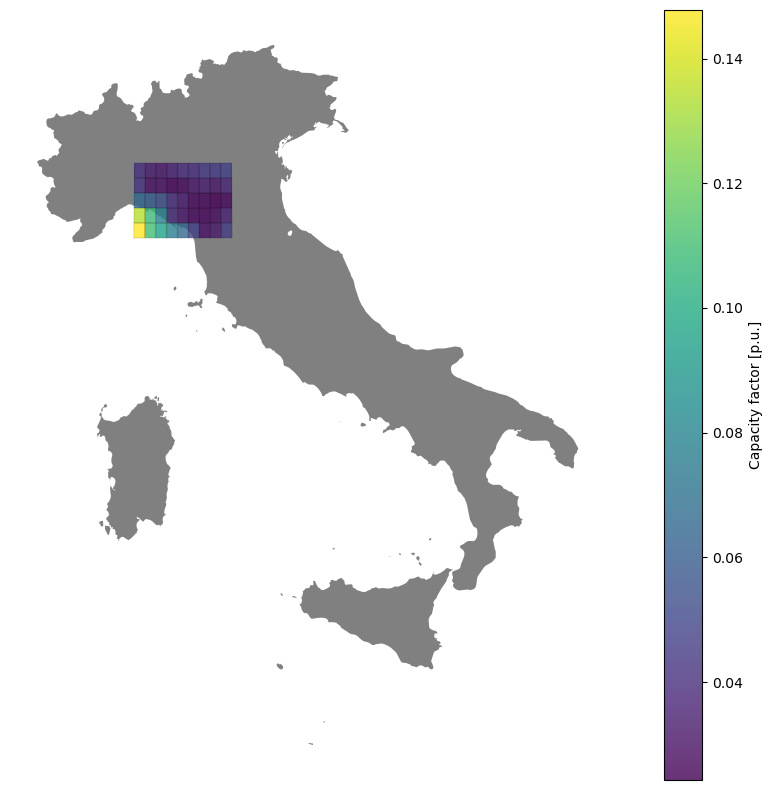

In [10]:
wind_opt = cutout.wind(
    turbine='Vestas_V112_3MW', smooth=True, capacity_factor=True
)

fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(12, 8))
Italy.plot(ax=ax, zorder=1, transform=plate(),color='grey',aspect="equal")
wind_opt.name = "Capacity factor"
wind_opt.plot(ax=ax, transform=plate(), alpha=0.8)
cells.plot(ax=ax, **plot_grid_dict)
ax.set_frame_on(False)
fig.tight_layout();

In [11]:
# PV produciton based on weather
pv_opt = cutout.pv(
    panel="CSi", orientation="latitude_optimal", clearsky_model="simple"
)
pv_opt

<xarray.DataArray 'specific generation' (y: 5, x: 9)>
array([[1374.57601848, 1380.72499738, 1385.56847193, 1389.56484627,
        1387.94402822, 1385.64235688, 1384.41680858, 1365.50820339,
        1349.5452044 ],
       [1321.67225498, 1330.14450627, 1342.54897842, 1359.77106746,
        1371.18227343, 1376.10224786, 1376.3986164 , 1357.9693632 ,
        1339.8546623 ],
       [1299.92235544, 1311.69056828, 1319.6401395 , 1326.1727973 ,
        1328.99489677, 1326.32198572, 1322.72897582, 1311.14094583,
        1303.94096832],
       [1282.77776573, 1293.03825419, 1299.76271398, 1298.88051951,
        1297.57807318, 1295.47720434, 1295.32828747, 1295.37124345,
        1290.33256789],
       [1271.81595107, 1279.3615923 , 1282.48689801, 1282.66592537,
        1282.14966117, 1284.61728194, 1286.07005716, 1287.0734068 ,
        1289.5317536 ]])
Coordinates:
  * y        (y) float64 44.0 44.25 44.5 44.75 45.0
    lat      (y) float64 44.0 44.25 44.5 44.75 45.0
  * x        (x) float64 9.0 9.25 9.5 9.75 10.0 10.25 10.5 10.75 11.0
    lon      (x) float64 9.0 9.25 9.5 9.75 10.0 10.25 10.5 10.75 11.0
Attributes:
    units:    kWh/kWp

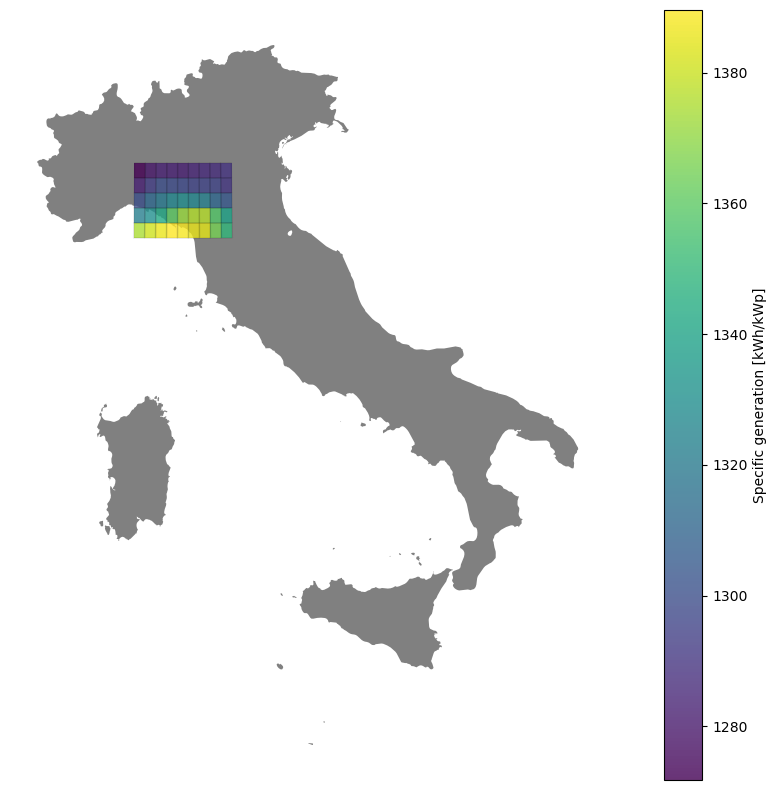

In [12]:
# Plotting PV capacity factors

fig, ax5 = plt.subplots(subplot_kw={"projection": projection}, figsize=(12, 8))
Italy.plot(ax=ax5, zorder=1, transform=plate(),color='grey',aspect="equal")
pv_opt.name = "Specific generation"
pv_opt.plot(ax=ax5, transform=plate(), alpha=0.8)
cells.plot(ax=ax5, **plot_grid_dict)
ax5.set_frame_on(False)
fig.tight_layout();

In [13]:
for t in atlite.windturbines:
    print(f"* {t}")

* Bonus_B1000_1000kW
* Enercon_E101_3000kW
* Enercon_E126_7500kW
* Enercon_E82_3000kW
* NREL_ReferenceTurbine_2016CACost_10MW_offshore
* NREL_ReferenceTurbine_2016CACost_6MW_offshore
* NREL_ReferenceTurbine_2016CACost_8MW_offshore
* NREL_ReferenceTurbine_2019ORCost_12MW_offshore
* NREL_ReferenceTurbine_2019ORCost_15MW_offshore
* NREL_ReferenceTurbine_2020ATB_12MW_offshore
* NREL_ReferenceTurbine_2020ATB_15MW_offshore
* NREL_ReferenceTurbine_2020ATB_18MW_offshore
* NREL_ReferenceTurbine_2020ATB_4MW
* NREL_ReferenceTurbine_2020ATB_5.5MW
* NREL_ReferenceTurbine_2020ATB_7MW
* NREL_ReferenceTurbine_5MW_offshore
* Siemens_SWT_107_3600kW
* Siemens_SWT_2300kW
* Suzlon_S82_1.5_MW
* Vestas_V112_3MW
* Vestas_V112_3MW_offshore
* Vestas_V164_7MW_offshore
* Vestas_V25_200kW
* Vestas_V47_660kW
* Vestas_V66_1750kW
* Vestas_V80_2MW_gridstreamer
* Vestas_V90_3MW


In [14]:
heat_demand = cutout.heat_demand(threshold=15.0, a=1.0, constant=0.0, hour_shift=1.0)
heat_demand

<xarray.DataArray 'heat_demand' (y: 5, x: 9)>
array([[ 381.56598,  400.5261 ,  438.9774 ,  540.668  ,  730.9109 ,
        1074.4287 , 1562.8275 , 1609.1802 , 1631.8723 ],
       [ 495.61798,  655.97253,  897.0791 , 1300.823  , 1656.2744 ,
        1975.0698 , 2231.4175 , 2020.258  , 1847.4976 ],
       [1452.5762 , 1661.9637 , 1798.2654 , 1940.2578 , 1963.316  ,
        1855.4952 , 1806.423  , 1622.6384 , 1504.6036 ],
       [1664.9478 , 1797.0687 , 1900.0991 , 1746.6224 , 1612.5854 ,
        1527.0286 , 1512.8291 , 1505.488  , 1415.6201 ],
       [1488.2808 , 1570.8306 , 1593.0692 , 1519.4059 , 1461.3385 ,
        1461.9834 , 1445.7377 , 1433.2745 , 1407.5409 ]], dtype=float32)
Coordinates:
  * x        (x) float64 9.0 9.25 9.5 9.75 10.0 10.25 10.5 10.75 11.0
  * y        (y) float64 44.0 44.25 44.5 44.75 45.0
    lon      (x) float64 9.0 9.25 9.5 9.75 10.0 10.25 10.5 10.75 11.0
    lat      (y) float64 44.0 44.25 44.5 44.75 45.0

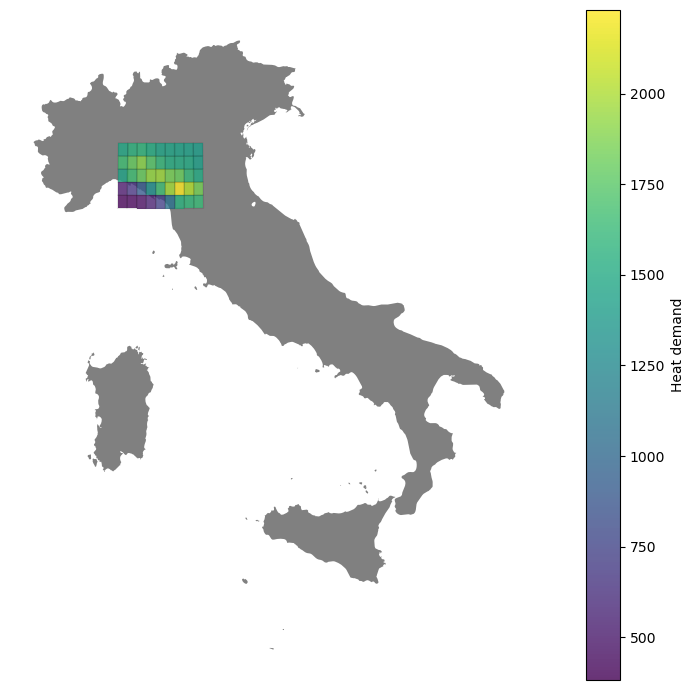

In [15]:
fig, ax5 = plt.subplots(subplot_kw={"projection": projection}, figsize=(12, 7))
Italy.plot(ax=ax5, zorder=1, transform=plate(),color='grey',aspect="equal")
heat_demand.name = "Heat demand"
heat_demand.plot(ax=ax5, transform=plate(), alpha=0.8)
cells.plot(ax=ax5, **plot_grid_dict)
ax5.set_frame_on(False)
fig.tight_layout();

  in_crs_string = _prepare_from_proj_string(in_crs_string)



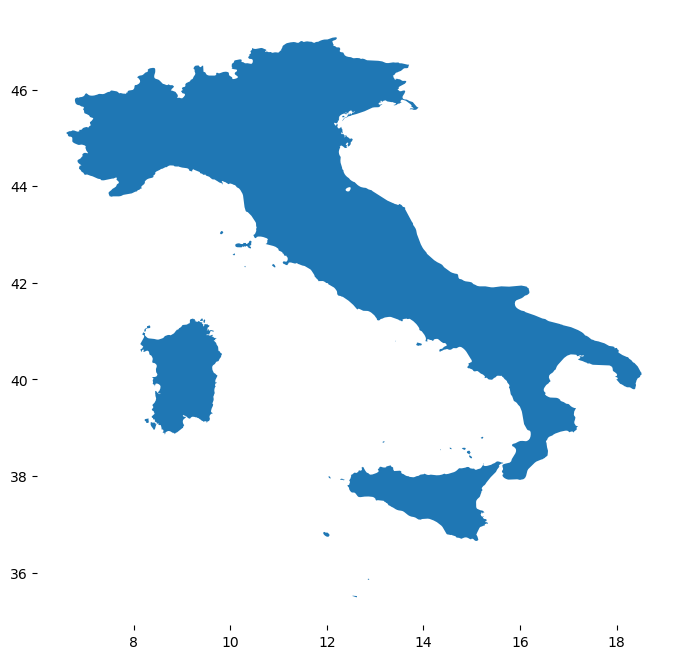

In [16]:
#Working with land use availability
Italy_fig = gpd.GeoSeries(
    {r.attributes["NAME_EN"]: r.geometry for r in reader.records()},
    crs={"init": "epsg:4326"},
).reindex(["Italy"]).plot(figsize=(12, 8),aspect="equal")
Italy_fig.set_frame_on(False)
#Italy.grid(True)


In [17]:
world = gpd.GeoSeries(
    {r.attributes["NAME_EN"]: r.geometry for r in reader.records()},
    crs={"init": "epsg:4326"},
).reindex(["Italy"])
world

# world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# countries = ["Italy"]
# shapes = world[world.name.isin(countries)].set_index("name")
# shapes
# shapes.plot(figsize=(12, 8));

  in_crs_string = _prepare_from_proj_string(in_crs_string)



Italy    MULTIPOLYGON (((7.02208 45.92526, 7.06694 45.8...
dtype: geometry

In [18]:
bounds = world.cascaded_union.buffer(1).bounds
cutout2 = atlite.Cutout(
    "Italy", module="era5", bounds=bounds, time=slice("2013-01-01", "2013-01-02")
)

  bounds = world.cascaded_union.buffer(1).bounds

  warn(



<Axes: >

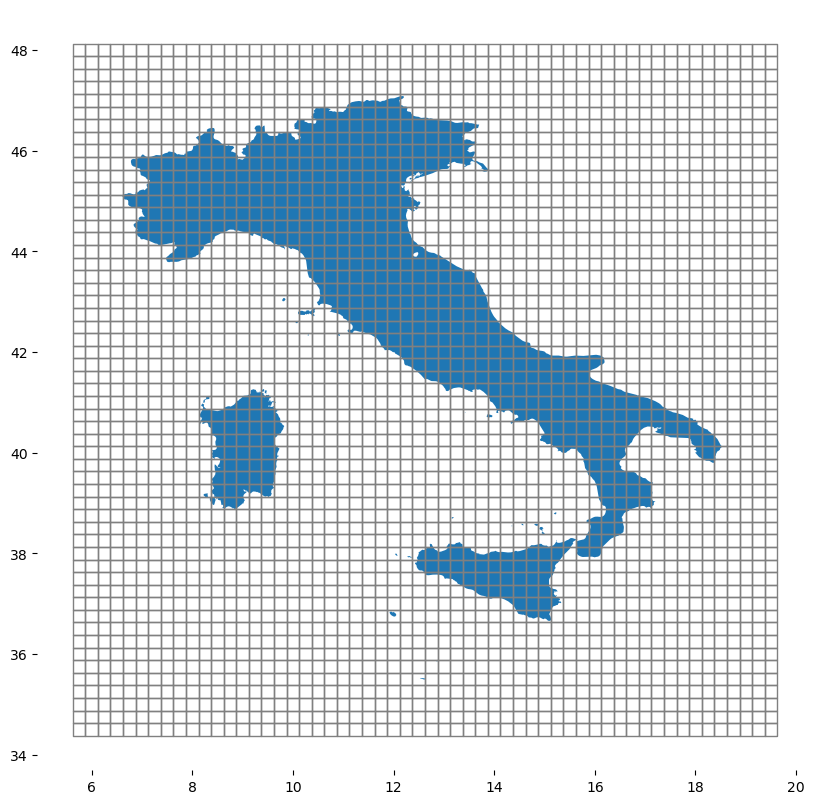

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
world.plot(ax=ax,aspect="equal").set_frame_on(False)
cutout2.grid.plot(ax=ax, edgecolor="grey", color="None",aspect="equal")

In [20]:
CORINE = "corine.tif"
excluder = ExclusionContainer()
excluder.add_raster(CORINE, codes=range(20))

In [21]:
italy = world.loc[["Italy"]].geometry.to_crs(excluder.crs)

In [22]:
masked, transform = shape_availability(italy, excluder)
eligible_share = masked.sum() * excluder.res**2 / italy.geometry.item().area
eligible_share

0.5767655957010753

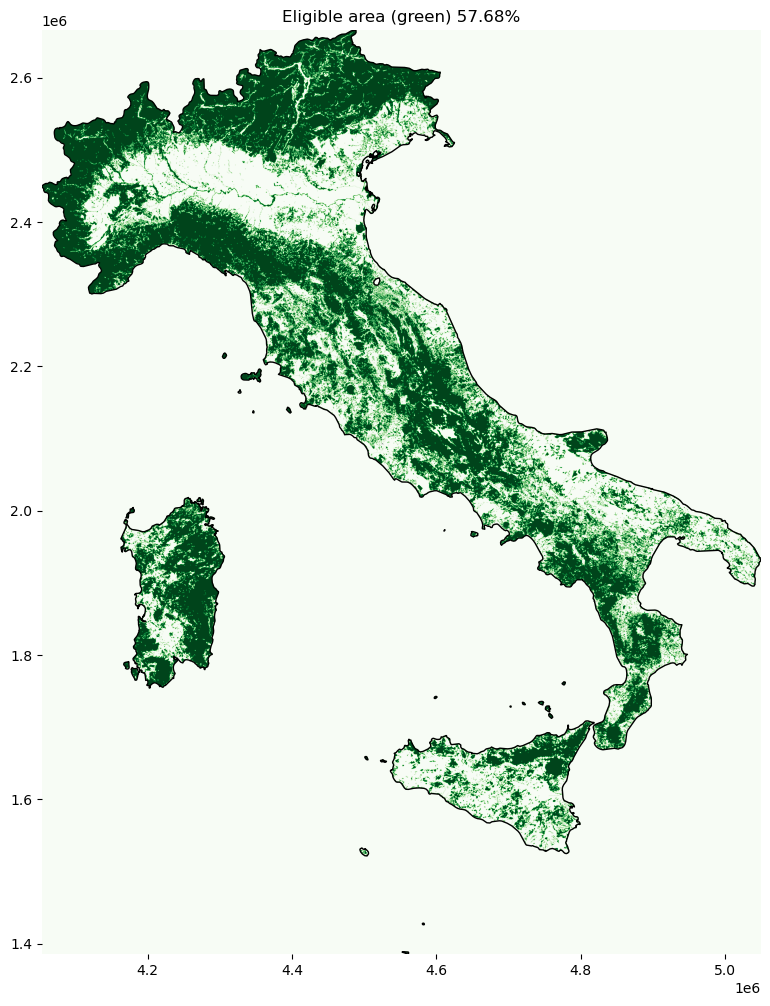

In [50]:
fig, ax = plt.subplots(figsize=(12, 12))
ax = show(masked, transform=transform, cmap="Greens", ax=ax)
italy.plot(ax=ax, edgecolor="k", color="None",aspect="equal").set_frame_on(False)
ax.set_title(f"Eligible area (green) {eligible_share * 100:2.2f}%");

In [24]:
A = cutout2.availabilitymatrix(world, excluder)
A

Compute availability matrix: 100%|██████████| 1/1 [00:04<00:00,  4.46s/ gridcells]


<xarray.DataArray (dim_0: 1, y: 55, x: 56)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * dim_0    (dim_0) object 'Italy'
  * y        (y) float64 34.5 34.75 35.0 35.25 35.5 ... 47.25 47.5 47.75 48.0
  * x        (x) float64 5.75 6.0 6.25 6.5 6.75 ... 18.5 18.75 19.0 19.25 19.5

<Axes: title={'center': 'dim_0 = Italy'}, xlabel='x', ylabel='y'>

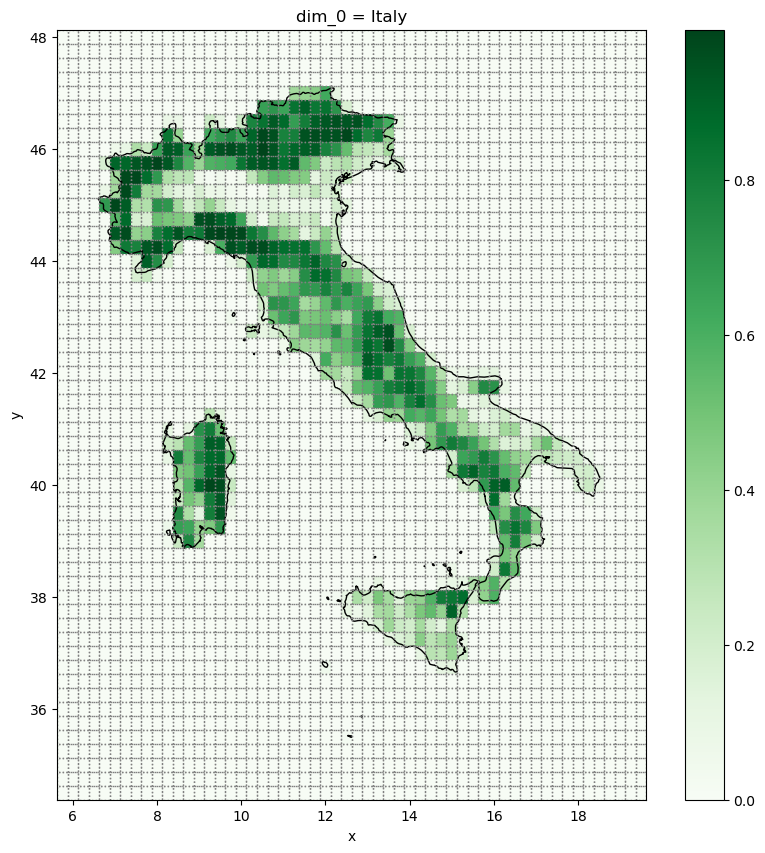

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
A.plot(cmap="Greens")
world.loc[["Italy"]].plot(ax=ax, edgecolor="k", color="None")
cutout2.grid.plot(ax=ax, color="None", edgecolor="grey", ls=":")

In [26]:
cap_per_sqkm = 1.7   # Setting installed capacity per unit area
area = cutout2.grid.set_index(["y", "x"]).to_crs(3035).area / 1e6
area = xr.DataArray(area, dims=("spatial"))

capacity_matrix = A.stack(spatial=["y", "x"]) * area * cap_per_sqkm

In [27]:
cutout2.prepare()
pv = cutout2.pv(
    matrix=capacity_matrix,
    panel=atlite.solarpanels.CdTe,
    orientation="latitude_optimal",
    index=world.index,
)

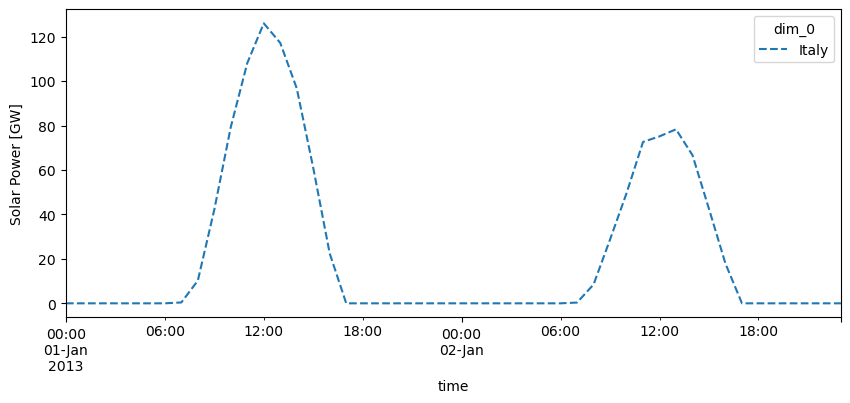

In [28]:
pv.to_pandas().div(1e3).plot(ylabel="Solar Power [GW]", ls="--", figsize=(10, 4));

In [29]:
pv

<xarray.DataArray 'specific generation' (time: 48, dim_0: 1)>
array([[     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [   389.98352992],
       [ 10199.11067775],
       [ 42178.99661415],
       [ 79377.44928511],
       [108155.37462389],
       [126031.36538307],
       [117198.84510041],
       [ 96757.12355821],
       [ 60970.40525652],
       [ 22408.39317215],
       [     0.        ],
       [     0.        ],
       [     0.        ],
...
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [   344.40266898],
       [  8485.16343972],
       [ 28729.94995247],
       [ 49554.90365391],
       [ 72647.15600258],
       [ 75156.48639709],
       [ 78328.2496825 ],
       [ 66661.10454991],
       [ 42494.82831963],
       [ 17852.7016118 ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ],
       [     0.        ]])
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-01-02T23:00:00
  * dim_0    (dim_0) object 'Italy'
Attributes:
    units:    MW